<a href="https://colab.research.google.com/github/fionaharia/ASL-landmark-detection/blob/main/data_collection_and_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTING LIBRARIES**

In [2]:
import os
import zipfile
import requests
import zipfile
from PIL import Image
from torchvision import transforms
import glob
import shutil
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **CREATING BASE DIRECTORIES FOR THE DATA**

In [4]:
base_dir = "/content/drive/MyDrive/OOD_Data"

# Raw data folders
raw_tiny = os.path.join(base_dir, "raw/tinyimagenet")
raw_ninco = os.path.join(base_dir, "raw/ninco")

# Preprocessed image folders
prep_tiny = os.path.join(base_dir, "preprocessed/tinyimagenet")
prep_ninco = os.path.join(base_dir, "preprocessed/ninco")

# Create directories
os.makedirs(raw_tiny, exist_ok=True)
os.makedirs(raw_ninco, exist_ok=True)
os.makedirs(prep_tiny, exist_ok=True)
os.makedirs(prep_ninco, exist_ok=True)

# **DOWNLOADING THE IN-DISTRIBUTION DATA**

In [5]:
tiny_url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
tiny_zip_path = '/content/tiny-imagenet-200.zip'

if not os.path.exists(os.path.join(raw_tiny, 'tiny-imagenet-200')):
    print("Downloading TinyImageNet...")
    with open(tiny_zip_path, 'wb') as f:
        f.write(requests.get(tiny_url).content)

    with zipfile.ZipFile(tiny_zip_path, 'r') as zip_ref:
        zip_ref.extractall(raw_tiny)

    print("Extracted to:", raw_tiny)

Extracted to: /content/drive/MyDrive/OOD_Data/raw/tinyimagenet


# **RESIZING AND NORMALIZING**

In [10]:
# Resize and normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Resize only for saving back to image
resize_only = transforms.Resize((224, 224))

# **PRE-PROCESSING FUNCTION**

In [11]:
def preprocess_and_save_images_recursive(input_root, output_root, limit=None):
    count = 0
    for root, _, files in os.walk(input_root):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                input_path = os.path.join(root, file)

                # Get relative path to recreate folder structure
                rel_path = os.path.relpath(input_path, input_root)
                output_path = os.path.join(output_root, rel_path)
                os.makedirs(os.path.dirname(output_path), exist_ok=True)

                try:
                    img = Image.open(input_path).convert('RGB')

                    # Resize + Normalize
                    img_tensor = transform(img)

                    # Convert normalized tensor back to image for saving
                    img_uint8 = img_tensor.mul(255).clamp(0, 255).byte().permute(1, 2, 0).numpy()
                    Image.fromarray(img_uint8).save(output_path)

                    count += 1
                    if limit and count >= limit:
                        print(f"Reached limit: {limit}")
                        return
                except Exception as e:
                    print(f"Error processing {input_path}: {e}")

    print(f"Finished processing. Saved {count} images to {output_root}")

# **PRE-PROCESSING DONE ON THE RAW DATA**

In [12]:
# Train set
preprocess_and_save_images_recursive(
    input_root=os.path.join(raw_tiny, 'tiny-imagenet-200/train'),
    output_root=os.path.join(prep_tiny, 'train'),
    limit=None
)

# Val set
preprocess_and_save_images_recursive(
    input_root=os.path.join(raw_tiny, 'tiny-imagenet-200/val'),
    output_root=os.path.join(prep_tiny, 'val')
)

# Test set
preprocess_and_save_images_recursive(
    input_root=os.path.join(raw_tiny, 'tiny-imagenet-200/test'),
    output_root=os.path.join(prep_tiny, 'test')
)

Finished processing. Saved 100000 images to /content/drive/MyDrive/OOD_Data/preprocessed/tinyimagenet/train
Finished processing. Saved 10000 images to /content/drive/MyDrive/OOD_Data/preprocessed/tinyimagenet/val
Finished processing. Saved 10000 images to /content/drive/MyDrive/OOD_Data/preprocessed/tinyimagenet/test


# **COMPARING RAW V/S PRE-PROCESSED IMAGE**

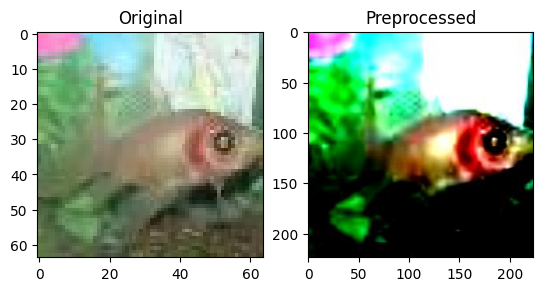

In [13]:
# Pick one image
original_img_path = os.path.join(raw_tiny, 'tiny-imagenet-200/train/n01443537/images', 'n01443537_0.JPEG')
processed_img_path = os.path.join(prep_tiny, 'train/n01443537/images', 'n01443537_0.JPEG')

# Load and show
original = Image.open(original_img_path).convert('RGB')
processed = Image.open(processed_img_path).convert('RGB')

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(original)

plt.subplot(1, 2, 2)
plt.title("Preprocessed")
plt.imshow(processed)
plt.show()